<a href="https://colab.research.google.com/github/UriB1/DL---X-ray-Image-Classification/blob/main/X_ray_Classification_Training_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train NoteBook Part 2

**Description:**

Training notebook for chest XRay classification based on unsupervised anomaly detection implemented with autoencoder.

**Usage guide:**

- Run setup tasks
- Run data preperation tasks
- Run model tasks
- Run evaluate tasks
- Run save tasks

## Setup

Import modules for the project

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
import shutil

Define constants and set up environment variables.

In [ ]:
SIZE = 256
batch_size = 64

# Base path of the dataset
base_path = "chest_xray"

# Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'username'
os.environ['KAGGLE_KEY'] = 'kay'

Check and download the dataset if not already present.

In [ ]:
# Check if dataset is downloaded; if not, download and unzip
if not os.path.exists("chest_xray"):
  os.system("kaggle datasets download -d paultimothymooney/chest-xray-pneumonia")
  os.system("unzip chest-xray-pneumonia.zip")

## Data Preperation

Data Preparation: Reorder images for data generators and divide the data into training, validation and testing datasets

In [ ]:
# Set the paths for training, val, and test sets
train_dir = '/content/chest_xray/train'
train_dir_n = '/content/chest_xray/train/NORMAL'
train_dir_p = '/content/chest_xray/train/PNEUMONIA'

val_dir = '/content/chest_xray/val'
val_dir_n = '/content/chest_xray/val/NORMAL'
val_dir_p = '/content/chest_xray/val/PNEUMONIA'

test_dir = '/content/chest_xray/test'

# Creating lists of the filenames of the train and val images
old_train_images_n, old_train_images_p = [f for f in os.listdir(train_dir_n) if os.path.isfile(os.path.join(train_dir_n, f))], [f for f in os.listdir(train_dir_p) if os.path.isfile(os.path.join(train_dir_p, f))]
old_val_images_n, old_val_images_p = [f for f in os.listdir(val_dir_n) if os.path.isfile(os.path.join(val_dir_n, f))], [f for f in os.listdir(val_dir_p) if os.path.isfile(os.path.join(val_dir_p, f))]

old_train_images = old_train_images_n + old_train_images_p
old_val_images = old_val_images_n + old_val_images_p
combined_images = old_train_images + old_val_images

# Split the data into training and validation sets
new_train_images, new_val_images = train_test_split(combined_images, test_size=0.2, random_state=42)

# Function to move images according to the split
directories = ['/content/chest_xray/train/NORMAL', '/content/chest_xray/train/PNEUMONIA', '/content/chest_xray/val/NORMAL', '/content/chest_xray/val/PNEUMONIA']
image_lists = [new_train_images, new_val_images]

# Function to move images according to the split
def move_images_by_name(images_lists, source_directory, directory_list):
  for filename in os.listdir(source_directory):
    source_file_path = os.path.join(source_directory, filename)

    if source_directory == directory_list[0] and filename in image_lists[1]:
      destination_file_path = os.path.join(directory_list[2], filename)
      shutil.move(source_file_path, destination_file_path)

    elif source_directory == directory_list[1] and filename in image_lists[1]:
      destination_file_path = os.path.join(directory_list[3], filename)
      shutil.move(source_file_path, destination_file_path)

    elif source_directory == directory_list[2] and filename in image_lists[0]:
      destination_file_path = os.path.join(directory_list[0], filename)
      shutil.move(source_file_path, destination_file_path)

    elif source_directory == directory_list[3] and filename in image_lists[0]:
      destination_file_path = os.path.join(directory_list[1], filename)
      shutil.move(source_file_path, destination_file_path)

# Moving all required images
move_images_by_name(image_lists, directories[0], directories)
move_images_by_name(image_lists, directories[1], directories)
move_images_by_name(image_lists, directories[2], directories)
move_images_by_name(image_lists, directories[3], directories)

Create data generators for training validation and testing

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    classes=['NORMAL'],
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    val_dir,
    classes=['NORMAL'],
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_unhealthy_generator = datagen.flow_from_directory(
    val_dir,
    classes=['PNEUMONIA'],
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False
    )

Found 1061 images belonging to 1 classes.
Found 288 images belonging to 1 classes.
Found 759 images belonging to 1 classes.
Found 624 images belonging to 2 classes.


## Model

Model Architecture - Sequential convolution autoencoder model

In [ ]:
# Model Creation
model = Sequential()

# Encoder
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))  # Reduced from 256 to 128
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))   # Kept at 64
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))   # Reduced from 64 to 32
model.add(MaxPooling2D((2, 2), padding='same'))

# Decoder
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))   # Matching with the last encoder layer
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))   # Increasing to 64
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))  # Increasing to 128
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same')) # Final layer with 3 filters

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)        0

Model Training - Train on traning dateset, validate against validation set, run for 30 epochs

In [ ]:
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch = 500 // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps = 75 // batch_size,
    shuffle=True
)

Epoch 1/10
7/7 [==============================] - 18s 3s/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 2/10
7/7 [==============================] - 14s 2s/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 3/10
7/7 [==============================] - 14s 2s/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 4/10
7/7 [==============================] - 14s 2s/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 5/10
7/7 [==============================] - 15s 2s/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 6/10
7/7 [==============================] - 15s 2s/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 7/10
7/7 [==============================] - 15s 2s/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 8/10
7/7 [==============================] - 15s 2s/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0

Visualizing Training

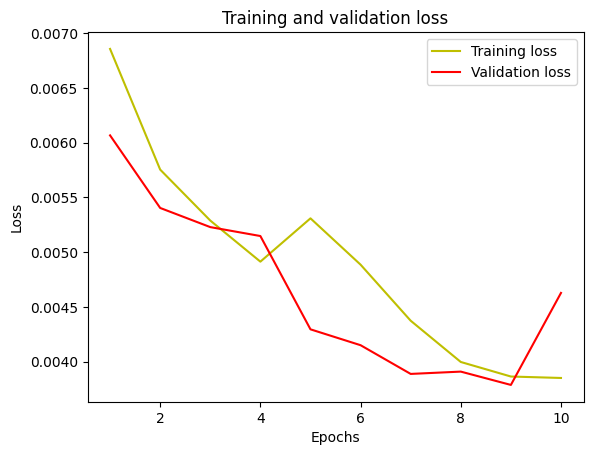

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Visualizing Reconstructions

1/1 [==============================] - 2s 2s/step


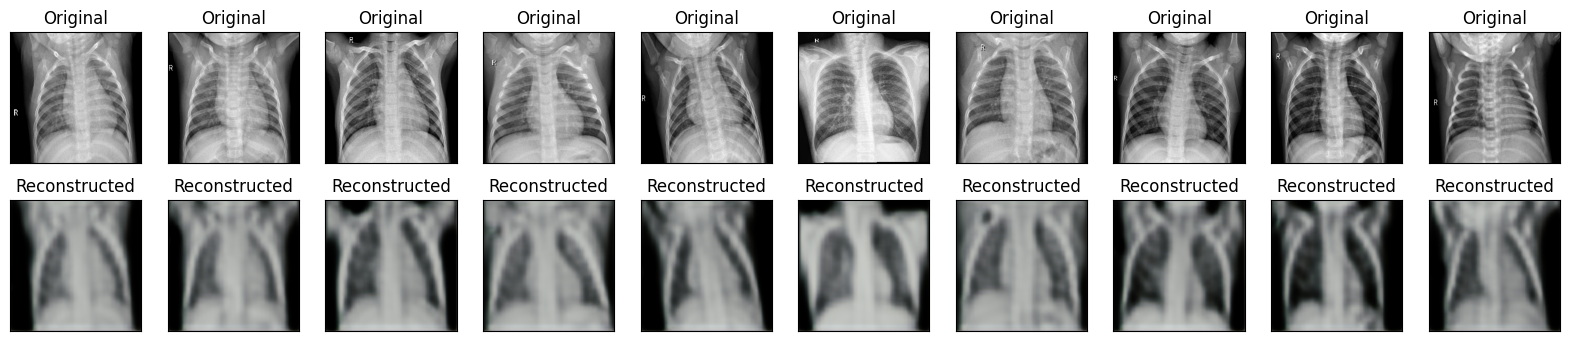

In [ ]:
# Fetch a batch of images from the generator
original_images, _ = next(train_generator)

# Generate reconstructed images
reconstructed_images = model.predict(original_images[:10])

# Plotting
plt.figure(figsize=(20, 4))
for i in range(10):
    # Display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(original_images[i].reshape(SIZE, SIZE, 3))
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(reconstructed_images[i].reshape(SIZE, SIZE, 3))
    plt.title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Evaluate

Evaluate the model performence - Calculates the MSE between actual and reconstructed images for a given dataset, Calssify the testing dataset by using the validation MSE as threshold

--- Val Healthy Average MSE ---
1/1 [==============================] - 0s 29ms/step


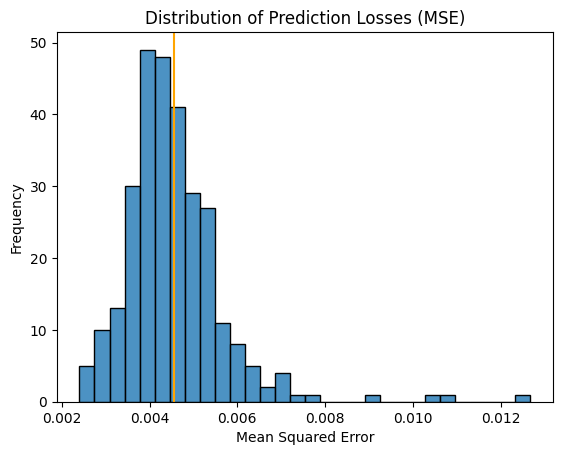

--- Val Unhealthy Average MSE ---
2/2 [==============================] - 0s 88ms/step


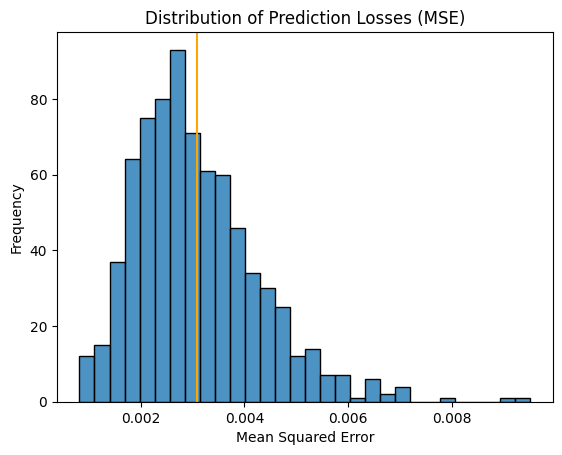

--- Test Classification Report ---
2/2 [==============================] - 0s 83ms/step
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       234
           1       0.76      0.76      0.76       390

    accuracy                           0.70       624
   macro avg       0.68      0.68      0.68       624
weighted avg       0.70      0.70      0.70       624

0.7019230769230769


In [ ]:
def evaluate_autoencoder_performance(generator, autoencoder):
    num_samples = generator.samples
    batch_size = generator.batch_size
    img_shape = generator.image_shape

    all_predictions = np.zeros((num_samples,) + img_shape, dtype=np.float32)
    all_actuals = np.zeros((num_samples,) + img_shape, dtype=np.float32)

    i = 0
    for images, _ in generator:
        num_images = images.shape[0]
        all_actuals[i:i + num_images] = images
        reconstructed_images = autoencoder.predict(images)
        all_predictions[i:i + num_images] = reconstructed_images
        i += num_images
        if i >= num_samples:
            break

    all_mses = np.mean(np.power(all_actuals - all_predictions, 2), axis=(1, 2, 3))
    avg_loss = np.mean(all_mses)

    sns.histplot(all_mses, bins=30, alpha=0.8)
    plt.axvline(x=avg_loss, color='orange')
    plt.title("Distribution of Prediction Losses (MSE)")
    plt.xlabel("Mean Squared Error")
    plt.ylabel("Frequency")
    plt.show()

    return avg_loss

def compute_classification_report(generator, autoencoder, avg_loss):
    num_samples = generator.samples
    batch_size = generator.batch_size
    img_shape = generator.image_shape

    all_predictions = np.zeros((num_samples,) + img_shape, dtype=np.float32)
    all_actuals = np.zeros((num_samples,) + img_shape, dtype=np.float32)
    all_labels = np.zeros(num_samples, dtype=np.int32)

    i = 0
    for images, labels in generator:
        num_images = images.shape[0]
        all_actuals[i:i + num_images] = images
        all_labels[i:i + num_images] = labels
        reconstructed_images = autoencoder.predict(images)
        all_predictions[i:i + num_images] = reconstructed_images
        i += num_images
        if i >= num_samples:
            break

    all_mses = np.mean(np.power(all_actuals - all_predictions, 2), axis=(1, 2, 3))
    threshold_predictions = [0 if mse > (avg_loss) else 1 for mse in all_mses]
    print(classification_report(generator.labels, threshold_predictions))
    print(accuracy_score(generator.labels, threshold_predictions))

# Evaluate performance and compute classification report
print("--- Val Healthy Average MSE ---")
avg_val_loss = evaluate_autoencoder_performance(validation_generator, model)
print("--- Val Unhealthy Average MSE ---")
avg_val_unhealthy_loss = evaluate_autoencoder_performance(validation_unhealthy_generator, model)


print("--- Test Classification Report ---")
compute_classification_report(test_generator, model, (avg_val_loss+avg_val_unhealthy_loss)/2)

## Save

In [ ]:
drive.mount('/content/drive')
model_save_path = '/content/drive/My Drive/MyModels/autoencoder_model.keras'
model.save(model_save_path)

Mounted at /content/drive
